In [1]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

In [3]:
from ROOT import TFile, TTree, TChain
print("All classes initialized succesfully.")

Welcome to JupyROOT 6.18/04
All classes initialized succesfully.


In [4]:
sigChan = TChain("varTree")
sigChan.Add("signal.root")
bkgChan = TChain("varTree")
bkgChan.Add("background.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [5]:
sigChan.Print()
bkgChan.Print()

******************************************************************************
*Chain   :varTree   : signal.root                                            *
******************************************************************************
******************************************************************************
*Tree    :varTree   : Input Variables List for Algorithms                    *
*Entries :    44440 : Total =         3213746 bytes  File  Size =    2732257 *
*        :          : Tree compression factor =   1.17                       *
******************************************************************************
*Br    0 :HtJet     : HtJet/D                                                *
*Entries :    44440 : Total  Size=     356973 bytes  File Size  =      24645 *
*Baskets :       12 : Basket Size=      32000 bytes  Compression=  14.46     *
*............................................................................*
*Br    1 :dRLL      : dRLL/D                        

In [6]:
# Read input data from root files
sigSampleSize = sigChan.GetEntries()
bkgSampleSize = bkgChan.GetEntries()
print(sigSampleSize)
print(bkgSampleSize)

44440
4108


In [7]:
# Convert the input data to matrices
sigFull = sigChan.AsMatrix()
bkgFull = bkgChan.AsMatrix()
print(sigFull[0])
print(sigFull.shape)
print(bkgFull.shape)

[ 0.          2.49833166  0.80792055  3.60755951  4.04035573  0.48130491
  0.32805805  0.29058502 70.49661585]
(44440, 9)
(4108, 9)


In [9]:
# Choose 20% of the data for testing and 80% of the data for training
sigTrain = sigFull[0:int(0.8*sigFull.shape[0])][:]
bkgTrain = bkgFull[0:int(0.8*bkgFull.shape[0])][:]
sigTest = sigFull[int(0.8*sigFull.shape[0]):][:]
bkgTest = bkgFull[int(0.8*bkgFull.shape[0]):][:]
print(sigTrain.shape)
print(bkgTrain.shape)
print(sigTest.shape)
print(bkgTest.shape)

(35552, 9)
(3286, 9)
(8888, 9)
(822, 9)


In [10]:
# Set a scaler for input features
scaler = StandardScaler()
scaler_input = np.concatenate((sigTrain,bkgTrain))
print(scaler.fit(scaler_input))
print(scaler.mean_)
joblib.dump(scaler, "scaler.save")

StandardScaler(copy=True, with_mean=True, with_std=True)
[ 3.26113929  2.85206341  0.71608697  7.10178975  2.41076365  1.64264783
  0.2280836   0.07920158 57.8950444 ]


['scaler.save']

In [11]:
# Build the model
per = m.Sequential()
per.add(l.Dense(18, input_dim=sigTrain.shape[1], activation='relu'))
per.add(l.Dropout(rate=0.2))
per.add(l.Dense(18, activation='relu'))
per.add(l.Dropout(rate=0.2))
per.add(l.Dense(2, activation='softmax'))
print("Model building complete!!!")

per.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Model building complete!!!


2020-02-26 21:08:43.380598: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


In [12]:
# Loop to change the training sample every time
# by randomly choosing from the avalaible sample space.
# Make sure to run atleast so that each and every event has been used once.

nShuffleRun = 10
trainingSampleSize = sigTrain.shape[0] if sigTrain.shape[0]<bkgTrain.shape[0] else bkgTrain.shape[0]
testSampleSize = sigTest.shape[0] if sigTest.shape[0]<bkgTest.shape[0] else bkgTest.shape[0]

print(trainingSampleSize)
print(testSampleSize)

3286
822


In [13]:
nEpochs = 100

lossTrain = []
lossTest = []
accTrain = []
accTest = []

for iterTrain in np.arange(nShuffleRun):
    
    sigTrainSampleRange = np.arange(sigTrain.shape[0])
    sigTrainSampleIndex = np.random.choice(sigTrainSampleRange, trainingSampleSize, replace=False)
    sigTrainChosen = sigTrain[sigTrainSampleIndex,:]
    bkgTrainSampleRange = np.arange(bkgTrain.shape[0])
    bkgTrainSampleIndex = np.random.choice(bkgTrainSampleRange, trainingSampleSize, replace=False)
    bkgTrainChosen = bkgTrain[bkgTrainSampleIndex,:]
    
    sigTestSampleRange = np.arange(sigTest.shape[0])
    sigTestSampleIndex = np.random.choice(sigTestSampleRange, testSampleSize, replace=False)
    sigTestChosen = sigTest[sigTestSampleIndex,:]
    bkgTestSampleRange = np.arange(bkgTest.shape[0])
    bkgTestSampleIndex = np.random.choice(bkgTestSampleRange, testSampleSize, replace=False)
    bkgTestChosen = bkgTest[bkgTestSampleIndex,:]
    
    #print(sigTrainChosen.shape)
    #print(bkgTrainChosen.shape)
    
    # Concatenate the signal and background with proper labels
    x = np.concatenate((sigTrainChosen,bkgTrainChosen))
    y = np.matrix([[1,0]]*sigTrainChosen.shape[0]+[[0,1]]*bkgTrainChosen.shape[0])
    x_test = np.concatenate((sigTestChosen,bkgTestChosen))
    y_test = np.matrix([[1,0]]*sigTestChosen.shape[0]+[[0,1]]*bkgTestChosen.shape[0])
    print("Feature Space: ",x.shape)
    
    # Randomize the training samples
    arr = np.arange(x.shape[0])
    np.random.shuffle(arr)
    x = x[arr,:]
    y = y[arr,:]
    
    # Scale the input features
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)
    
    history = per.fit(x, 
                      y, 
                      validation_data=(x_test, y_test), 
                      epochs=nEpochs, 
                      batch_size=int(0.1*x.shape[0]))
    
    lossTrain.extend(history.history['loss'])
    lossTest.extend(history.history['val_loss'])
    accTrain.extend(history.history['accuracy'])
    accTest.extend(history.history['val_accuracy'])


Feature Space:  (6572, 9)
Train on 6572 samples, validate on 1644 samples
Epoch 1/100
6572/6572 [==============================] - 1s 119us/sample - loss: 0.9523 - accuracy: 0.4629 - val_loss: 1.0367 - val_accuracy: 0.4300
Epoch 2/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.8104 - accuracy: 0.5038 - val_loss: 0.8471 - val_accuracy: 0.5432
Epoch 3/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.7335 - accuracy: 0.5332 - val_loss: 0.7257 - val_accuracy: 0.5845
Epoch 4/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.6957 - accuracy: 0.5670 - val_loss: 0.6320 - val_accuracy: 0.6332
Epoch 5/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.6498 - accuracy: 0.5948 - val_loss: 0.5952 - val_accuracy: 0.6575
Epoch 6/100
6572/6572 [==============================] - 0s 13us/sample - loss: 0.6267 - accuracy: 0.6121 - val_loss: 0.5736 - val_accuracy: 0.6831
Epoch 7/100
6572/6572 [=================

Epoch 10/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3755 - accuracy: 0.8171 - val_loss: 0.3411 - val_accuracy: 0.8339
Epoch 11/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3713 - accuracy: 0.8211 - val_loss: 0.3406 - val_accuracy: 0.8345
Epoch 12/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3721 - accuracy: 0.8194 - val_loss: 0.3405 - val_accuracy: 0.8364
Epoch 13/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3743 - accuracy: 0.8180 - val_loss: 0.3402 - val_accuracy: 0.8376
Epoch 14/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3774 - accuracy: 0.8186 - val_loss: 0.3409 - val_accuracy: 0.8345
Epoch 15/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3753 - accuracy: 0.8223 - val_loss: 0.3408 - val_accuracy: 0.8358
Epoch 16/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3743 - accuracy: 0.8174 - val_

Epoch 20/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3371 - accuracy: 0.8471 - val_loss: 0.3321 - val_accuracy: 0.8437
Epoch 21/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3378 - accuracy: 0.8443 - val_loss: 0.3313 - val_accuracy: 0.8498
Epoch 22/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3413 - accuracy: 0.8427 - val_loss: 0.3313 - val_accuracy: 0.8498
Epoch 23/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3400 - accuracy: 0.8449 - val_loss: 0.3315 - val_accuracy: 0.8504
Epoch 24/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3429 - accuracy: 0.8405 - val_loss: 0.3314 - val_accuracy: 0.8467
Epoch 25/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3392 - accuracy: 0.8440 - val_loss: 0.3339 - val_accuracy: 0.8406
Epoch 26/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3403 - accuracy: 0.8463 - val_

Epoch 30/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3442 - accuracy: 0.8354 - val_loss: 0.3296 - val_accuracy: 0.8437
Epoch 31/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.3441 - accuracy: 0.8390 - val_loss: 0.3295 - val_accuracy: 0.8461
Epoch 32/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3453 - accuracy: 0.8419 - val_loss: 0.3294 - val_accuracy: 0.8461
Epoch 33/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3416 - accuracy: 0.8398 - val_loss: 0.3293 - val_accuracy: 0.8473
Epoch 34/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3455 - accuracy: 0.8392 - val_loss: 0.3295 - val_accuracy: 0.8437
Epoch 35/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3444 - accuracy: 0.8392 - val_loss: 0.3307 - val_accuracy: 0.8418
Epoch 36/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3490 - accuracy: 0.8416 

Epoch 40/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3481 - accuracy: 0.8389 - val_loss: 0.3298 - val_accuracy: 0.8455
Epoch 41/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3476 - accuracy: 0.8367 - val_loss: 0.3299 - val_accuracy: 0.8461
Epoch 42/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3488 - accuracy: 0.8393 - val_loss: 0.3299 - val_accuracy: 0.8461
Epoch 43/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3503 - accuracy: 0.8349 - val_loss: 0.3323 - val_accuracy: 0.8388
Epoch 44/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3485 - accuracy: 0.8360 - val_loss: 0.3323 - val_accuracy: 0.8400
Epoch 45/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3440 - accuracy: 0.8398 - val_loss: 0.3321 - val_accuracy: 0.8412
Epoch 46/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3512 - accuracy: 0.8376 - val_

6572/6572 [==============================] - 0s 4us/sample - loss: 0.3384 - accuracy: 0.8442 - val_loss: 0.3294 - val_accuracy: 0.8370
Epoch 50/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3399 - accuracy: 0.8379 - val_loss: 0.3288 - val_accuracy: 0.8388
Epoch 51/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3380 - accuracy: 0.8437 - val_loss: 0.3290 - val_accuracy: 0.8412
Epoch 52/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3418 - accuracy: 0.8414 - val_loss: 0.3325 - val_accuracy: 0.8473
Epoch 53/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3398 - accuracy: 0.8390 - val_loss: 0.3320 - val_accuracy: 0.8467
Epoch 54/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3409 - accuracy: 0.8381 - val_loss: 0.3307 - val_accuracy: 0.8437
Epoch 55/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3337 - accuracy: 0.8451 - val_loss: 0.3295 

Epoch 4/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3350 - accuracy: 0.8484 - val_loss: 0.3257 - val_accuracy: 0.8516
Epoch 5/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3347 - accuracy: 0.8454 - val_loss: 0.3253 - val_accuracy: 0.8504
Epoch 6/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3378 - accuracy: 0.8439 - val_loss: 0.3250 - val_accuracy: 0.8491
Epoch 7/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3310 - accuracy: 0.8488 - val_loss: 0.3252 - val_accuracy: 0.8485
Epoch 8/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3338 - accuracy: 0.8488 - val_loss: 0.3256 - val_accuracy: 0.8498
Epoch 9/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3349 - accuracy: 0.8492 - val_loss: 0.3256 - val_accuracy: 0.8510
Epoch 10/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3341 - accuracy: 0.8445 - val_

Epoch 14/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3368 - accuracy: 0.8387 - val_loss: 0.3208 - val_accuracy: 0.8449
Epoch 15/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3367 - accuracy: 0.8443 - val_loss: 0.3209 - val_accuracy: 0.8449
Epoch 16/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3327 - accuracy: 0.8421 - val_loss: 0.3201 - val_accuracy: 0.8455
Epoch 17/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3372 - accuracy: 0.8408 - val_loss: 0.3199 - val_accuracy: 0.8437
Epoch 18/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3339 - accuracy: 0.8436 - val_loss: 0.3199 - val_accuracy: 0.8437
Epoch 19/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3342 - accuracy: 0.8411 - val_loss: 0.3204 - val_accuracy: 0.8425
Epoch 20/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3366 - accuracy: 0.8402 - val_

Epoch 24/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3250 - accuracy: 0.8507 - val_loss: 0.3186 - val_accuracy: 0.8534
Epoch 25/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3276 - accuracy: 0.8491 - val_loss: 0.3185 - val_accuracy: 0.8546
Epoch 26/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3278 - accuracy: 0.8484 - val_loss: 0.3200 - val_accuracy: 0.8510
Epoch 27/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3267 - accuracy: 0.8491 - val_loss: 0.3201 - val_accuracy: 0.8516
Epoch 28/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3284 - accuracy: 0.8513 - val_loss: 0.3190 - val_accuracy: 0.8558
Epoch 29/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3278 - accuracy: 0.8527 - val_loss: 0.3183 - val_accuracy: 0.8564
Epoch 30/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3278 - accuracy: 0.8492 - val_

Epoch 34/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3294 - accuracy: 0.8484 - val_loss: 0.3299 - val_accuracy: 0.8412
Epoch 35/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3316 - accuracy: 0.8472 - val_loss: 0.3306 - val_accuracy: 0.8485
Epoch 36/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3354 - accuracy: 0.8427 - val_loss: 0.3298 - val_accuracy: 0.8491
Epoch 37/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3264 - accuracy: 0.8469 - val_loss: 0.3293 - val_accuracy: 0.8467
Epoch 38/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3305 - accuracy: 0.8459 - val_loss: 0.3297 - val_accuracy: 0.8425
Epoch 39/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3307 - accuracy: 0.8474 - val_loss: 0.3291 - val_accuracy: 0.8425
Epoch 40/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3295 - accuracy: 0.8495 - val_

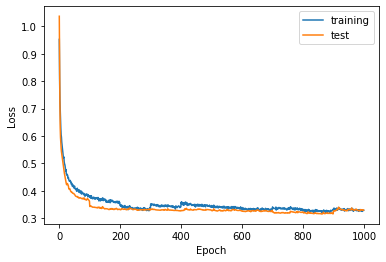

In [14]:
# Training Curve
plt.clf()
plt.plot(lossTrain, label='training')
plt.plot(lossTest, label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.pdf")

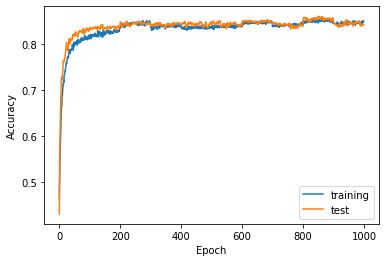

In [15]:
plt.clf()
plt.plot(accTrain, label='training')
plt.plot(accTest, label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.pdf")